## Subsampling analysis

subsample the number of inidvidualas/RNA-seq datasets and look at how number of signals changes

In [1]:
import pandas as pd
import numpy as np
import os
import yaml
import seaborn as sns


prefix = '/home/klawren/oak/pcqtls'


### create the subsampled expression and covar files
this only needs to be run once

In [4]:
# get outputs from a config file
config_path= f'{prefix}/config/tami_clusters/proteincoding.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

tissue_id_path = config['tissue_id_path']
clusters_dir = config['clusters_dir']
expression_dir = config['expression_dir']
covariates_dir = config['covariates_dir']

tissue_df = pd.read_csv(f"{prefix}/{tissue_id_path}", header=0)
tissue_ids = list(tissue_df['Tissue'])
tissue_id = 'Cells_Cultured_fibroblasts'

In [3]:
# minimum of 300 in each tissue, I'll do 100, 200, 300

for num_samples in [75,150,250]:
    output_dir = f'{prefix}/data/processed/subsampling/{num_samples}'
    os.mkdir(output_dir)
    os.mkdir(f'{output_dir}/covariates/')
    os.mkdir(f'{output_dir}/normalized_expression/')

    for tissue_id in tissue_ids:
        # load in each expression and covariates files
        expression_df = pd.read_csv(f'{prefix}/{expression_dir}/{tissue_id}.v8.normalized_expression.bed', sep='\t')
        covariates_df = pd.read_csv(f'{prefix}/{covariates_dir}/{tissue_id}.v8.covariates.txt', sep='\t', index_col=0).T

        selected_samples = covariates_df.index[:num_samples].values

        # write out first x as a subset
        sub_expression = expression_df[np.concatenate([expression_df.columns[:4].values, selected_samples])]
        sub_expression.to_csv(f'{output_dir}/normalized_expression/{tissue_id}.v8.normalized_expression.bed', sep='\t', index=None)

        sub_covar = covariates_df.loc[selected_samples]
        sub_covar.T.to_csv(f'{output_dir}/covariates/{tissue_id}.v8.covariates.txt', sep='\t')

FileExistsError: [Errno 17] File exists: '/home/klawren/oak/pcqtls/data/processed/subsampling/75'

In [28]:
# try with a random selection of 100 rather than the first 100
for num_samples in [100]:
    output_dir = f'{prefix}/data/processed/subsampling/{num_samples}_rand'
    try:
        os.mkdir(output_dir)
        os.mkdir(f'{output_dir}/covariates/')
        os.mkdir(f'{output_dir}/normalized_expression/')
    except FileExistsError:
        pass

    for tissue_id in tissue_ids:
        # load in each expression and covariates files
        expression_df = pd.read_csv(f'{prefix}/{expression_dir}/{tissue_id}.v8.normalized_expression.bed', sep='\t')
        covariates_df = pd.read_csv(f'{prefix}/{covariates_dir}/{tissue_id}.v8.covariates.txt', sep='\t', index_col=0).T

        selected_samples = pd.Series(covariates_df.index.values).sample(num_samples)

        sub_expression = expression_df[np.concatenate([expression_df.columns[:4].values, selected_samples])]
        sub_expression.to_csv(f'{output_dir}/normalized_expression/{tissue_id}.v8.normalized_expression.bed', sep='\t', index=None)

        sub_covar = covariates_df.loc[selected_samples]
        sub_covar.T.to_csv(f'{output_dir}/covariates/{tissue_id}.v8.covariates.txt', sep='\t')

I then run snakemake on each of these 4 to get the QTLs with config files in config/subsampling/


this next analysis assumes results in those folders

In [2]:
subsample_output_folder = f'{prefix}/config/subsampling'

### Number QTLs across subsamples

In [3]:
# load in the configs for each 

subsample_nums = [100,200,300]

sub_config = {}
for num_samples in subsample_nums:
    config_path= f'{subsample_output_folder}/{num_samples}_subsample.yaml'
    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)
        sub_config[num_samples] = config

tissue_id_path = config['tissue_id_path']
tissue_df = pd.read_csv(f"{prefix}/{tissue_id_path}", header=0)
tissue_ids = list(tissue_df['Tissue'])
tissue_pal = sns.color_palette('blend:#B83A4B,#FEC51D,#67AFD2', n_colors=len(tissue_ids))


tissue_id = 'Cells_Cultured_fibroblasts'

In [14]:
# to load the random 100 (rather than 1st 100)
# for num_samples in [101]:
#     config_path= f'{prefix}/config/subsampling/{num_samples-1}_rand_subsample.yaml'
#     with open(config_path, 'r') as f:
#         config = yaml.safe_load(f)
#         sub_config[num_samples] = config

In [4]:
def get_qtl_counts(tissue_id, config):
    overlap_df = pd.read_csv('{}/{}/{}.v8.overlap.txt'.format(prefix, config['overlap_output_dir'], tissue_id), sep='\t')
    return overlap_df.groupby('orig_cs_dataset').count()['cs_full_id']

def get_cluster_count(tissue_id, config):
    cluster_df = pd.read_csv('{}/{}/{}_clusters_all_chr.csv'.format(prefix, config['clusters_dir'], tissue_id))
    return len(cluster_df)

def get_egene_count(tissue_id, config):
    overlap_df = pd.read_csv('{}/{}/{}.v8.overlap.txt'.format(prefix, config['overlap_output_dir'], tissue_id), sep='\t')
    if len(overlap_df) == 0:
        return 0
    else:
        return len(set(np.concatenate(overlap_df['cluster_id'].str.split('_'))))

def get_counts(config):
    counts = tissue_df['Tissue'].apply(get_qtl_counts, args=(config,))
    counts = tissue_df.join(counts)
    counts['clusters'] = counts['Tissue'].apply(get_cluster_count, args=(config,))
    counts['egenes'] = counts['Tissue'].apply(get_egene_count, args=(config,))
    return counts

In [19]:
sub_counts = []
for num_samples in [*subsample_nums, 101]:
    sub_counts.append(get_counts(sub_config[num_samples]))

In [25]:
joined_count_df = pd.concat(sub_counts, keys=[*subsample_nums, 101], names=['num_samples', 'idx'])
joined_count_df.fillna(0, inplace=True)
joined_count_df.reset_index(level=0, inplace=True)
joined_counts = joined_count_df.melt(id_vars=['Tissue', 'num_samples'], var_name='count_type', value_name='count')

In [26]:
joined_count_df

,num_samples,Tissue,control_eqtl,pc_qtl,clusters,egenes
idx,,,,,,
0,100,Adipose_Subcutaneous,2307,2326,683,1432
1,100,Adipose_Visceral_Omentum,2112,2157,615,1320
2,100,Artery_Tibial,1874,1904,547,1161
3,100,Cells_Cultured_fibroblasts,1862,1853,539,1162
4,100,Esophagus_Mucosa,1966,1999,572,1225
5,100,Esophagus_Muscularis,1626,1647,487,1028
6,100,Lung,2484,2519,719,1517
7,100,Muscle_Skeletal,1635,1677,475,997
8,100,Nerve_Tibial,2147,2178,632,1362


Text(0.5, 0.98, 'Subsampled counts')

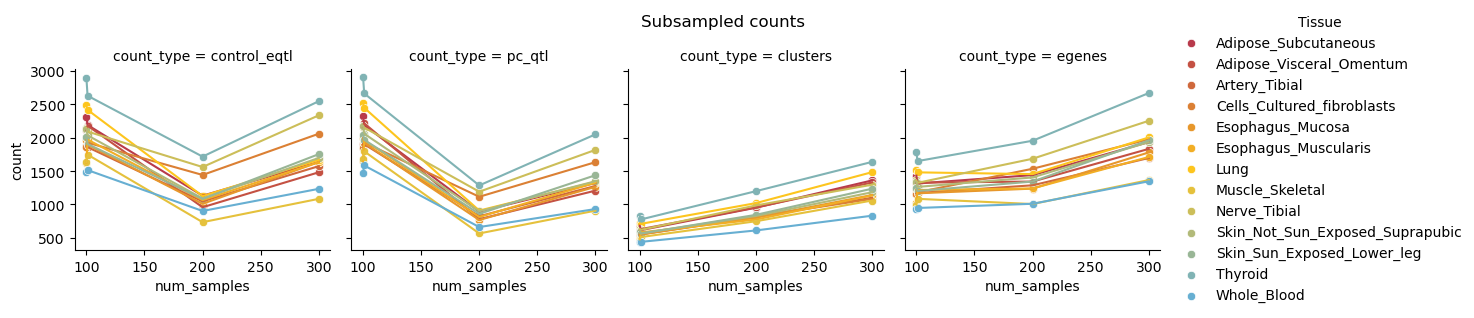

In [27]:
g = sns.FacetGrid(joined_counts, col="count_type", hue='Tissue', palette = tissue_pal)
g.map(sns.lineplot, "num_samples", "count")
g.map(sns.scatterplot, "num_samples", "count")
g.add_legend()
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle('Subsampled counts')